In [1]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 8.1 MB/s 


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import numpy as np
import pandas as pd
import random
import collections
import json
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/MyDrive/dataset/AI_Hub/Kor_JP_corpus'

df=pd.read_csv(file_path+'/ko2ja_kpop_1_training.csv')


In [5]:
df

,관리번호,분야,한국어,일본어,한국어_어절수,일본어_글자수,길이_분류,출처,수행기관
0,KO-JA-2020-KPOP-000501,K-POP(한류)/대중문화공연콘텐츠,소속사 측은 두 사람이 친한 것은 맞지만 결혼설은 사실무근이라고 강조했다.,所属事務所側は、2人が親しいのは事実だが、結婚説は事実無根だと強調した。,10,32,2,http://en.seoul.co.kr/news/newsView.php?id=201...,플리토
1,KO-JA-2020-KPOP-000502,K-POP(한류)/대중문화공연콘텐츠,"이런 가운데, 석 씨는 ""건너편에서 장사를 하던 '영훈이네'가 3개월째 안 나오고 ...",この中で、ソク氏は「向い側で商売をしていた『ヨンフンら』が3ヶ月も出てきてなくて、アイコンタ...,15,54,3,http://www.sedaily.com/NewsView/1Z2T8EVRIB,플리토
2,KO-JA-2020-KPOP-000503,K-POP(한류)/대중문화공연콘텐츠,"아직도 차유리를 잃은 트라우마를 겪는 조강화, 저마다의 방법으로 차유리를 가슴에 묻...",未だにチャ・ユリを失ったトラウマを体験するチョ・カンファ、それぞれの方法でチャ・ユリを心に秘...,28,122,5,http://www.sedaily.com/NewsView/1YZ1P5CJLP,플리토
3,KO-JA-2020-KPOP-000504,K-POP(한류)/대중문화공연콘텐츠,정말 평범한 사람인데 그 사람에게 큰 사건이 일어나며 대처와 진실을 알고자 했던 과...,本当に普通の人であるが、その人に大きな事件が起き、対処と真実を理解しようとした過程が良かった。,14,44,2,http://uci.or.kr/G703:RA101-10100101.201907031...,플리토
4,KO-JA-2020-KPOP-000505,K-POP(한류)/대중문화공연콘텐츠,"'별, 빛(Starlight)'을 시작으로, 달콤한 목소리가 매력적인 'Got Yo...",「星光(Starlight)」をはじめ、甘い声が魅力的な「Got Your Back(ゴット...,19,52,3,http://www.sedaily.com/NewsView/1YXJJAPF9E,플리토
...,...,...,...,...,...,...,...,...,...
159995,KO-JA-2020-KPOP-160496,K-POP(한류)/대중문화공연콘텐츠,이세은은 감정이 북받친 듯 눈물을 쏟으며 노래도 제대로 부르지 못했다.,イ・セウンは感情が込み上げてきたように涙を流し、歌もまともに歌えなかった。,10,34,2,http://en.seoul.co.kr/news/newsView.php?id=201...,플리토
159996,KO-JA-2020-KPOP-160497,K-POP(한류)/대중문화공연콘텐츠,이날 팬 미팅에서는 장성규와 팬들 사이에서 끊임없는 '선 넘기' 상황이 펼쳐져 사람...,この日のファンミーティングでは、チャン・ソンギュとファンの間で絶えない「線を越える」状況が繰...,16,58,3,http://news.kmib.co.kr/article/view.asp?arcid=...,플리토
159997,KO-JA-2020-KPOP-160498,K-POP(한류)/대중문화공연콘텐츠,대한민국 최고 배우들의 환장케미가 만들어내는 완벽한 웃음과 감동으로 개봉 전부터 관...,韓国最高の俳優たちの気がおかしくなりそうな相性が作り出す完璧な笑いと感動で公開の前から観客の...,20,71,4,http://www.sedaily.com/NewsView/1VODRE9U1J,플리토
159998,KO-JA-2020-KPOP-160499,K-POP(한류)/대중문화공연콘텐츠,쿠바의 풍광과 여행 과정에서 겪는 소소한 에피소드들이 두 명품 배우의 중저음 나레이...,キューバの景色と旅行過程で体験する些細なエピソードが、2人の一流俳優の重低音のナレーションと...,15,54,3,http://news.kmib.co.kr/article/view.asp?arcid=...,플리토


In [6]:
with open("kor_corpus.txt", "w") as f:
    for line in list(df['한국어']):
        f.write(line.strip())
        f.write("\n")

In [7]:
with open("jp_corpus.txt", "w") as f:
    for line in list(df['일본어']):
        f.write(line.strip())
        f.write("\n")

In [8]:
def train_sentencepiece(corpus, prefix, vocab_size):
    """
    sentencepiece를 이용해 vocab 학습
    :param corpus: 학습할 말뭉치
    :param prefix: 저장할 vocab 이름
    :param vocab_size: vocab 개수
    """
    spm.SentencePieceTrainer.train(
        f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size + 7}" +  # 7은 특수문자 개수
        " --model_type=unigram" +
        # " --model_type=bpe" +
        " --max_sentence_length=999999" +  # 문장 최대 길이
        " --pad_id=0 --pad_piece=[PAD]" +  # pad token 및 id 지정
        " --unk_id=1 --unk_piece=[UNK]" +  # unknown token 및 id 지정
        " --bos_id=2 --bos_piece=[BOS]" +  # begin of sequence token 및 id 지정
        " --eos_id=3 --eos_piece=[EOS]" +  # end of sequence token 및 id 지정
        " --user_defined_symbols=[SEP],[CLS],[MASK]")  # 기타 추가 토큰 SEP: 4, CLS: 5, MASK: 6

In [9]:
train_sentencepiece(f"kor_corpus.txt", f"kor_corpus", vocab_size=6000) # 단어 숫자는 아래의 토큰 분리를 보며 임의로 지정함. 되도록 토큰이 분리되도록 지정 

In [10]:
train_sentencepiece(f"jp_corpus.txt", f"jp_corpus", vocab_size=4000) # 단어 숫자는 아래의 토큰 분리를 보며 임의로 지정함. 되도록 토큰이 분리되도록 지정 

In [11]:
kor_vocab = spm.SentencePieceProcessor()
kor_vocab.load(f"kor_corpus.model")

True

In [12]:
jp_vocab = spm.SentencePieceProcessor()
jp_vocab.load(f"jp_corpus.model")

True

In [14]:
pieces = kor_vocab.encode_as_pieces(df['한국어'].loc[11])
pieces

['▁우',
 '아',
 '하고',
 '▁기',
 '품',
 '▁있어',
 '▁보이지',
 '만',
 ',',
 '▁목표',
 '가',
 '▁생기',
 '면',
 '▁',
 '쟁',
 '취',
 '하고',
 '야',
 '▁마',
 '는',
 '▁강한',
 '▁집',
 '념',
 '을',
 '▁가진',
 '▁여',
 '인',
 '이다',
 '.']

In [18]:
pieces = jp_vocab.encode_as_pieces(df['일본어'].loc[11])
pieces

['▁',
 'エ',
 'レ',
 'ガン',
 'ト',
 'で',
 '気',
 '品',
 'がある',
 'ように',
 '見える',
 'が',
 '、',
 '目',
 '標',
 'で',
 'あ',
 'れば',
 '勝',
 'ち',
 '取',
 'って',
 'し',
 'ま',
 'う',
 '強い',
 '執',
 '念',
 'を持った',
 '女性',
 'だ',
 '。']

In [16]:
# vocab 출력
print(f"len: {len(kor_vocab)}")
for id in range(20):
    print(f"{id:2d}: {kor_vocab.id_to_piece(id)}")

len: 6007
 0: [PAD]
 1: [UNK]
 2: [BOS]
 3: [EOS]
 4: [SEP]
 5: [CLS]
 6: [MASK]
 7: ▁
 8: .
 9: 을
10: 의
11: 이
12: 가
13: ,
14: '
15: ▁'
16: 는
17: 를
18: 에
19: 은


In [17]:
# vocab 출력
print(f"len: {len(jp_vocab)}")
for id in range(20):
    print(f"{id:2d}: {jp_vocab.id_to_piece(id)}")

len: 4007
 0: [PAD]
 1: [UNK]
 2: [BOS]
 3: [EOS]
 4: [SEP]
 5: [CLS]
 6: [MASK]
 7: 、
 8: の
 9: が
10: 。
11: を
12: ・
13: ▁
14: に
15: 」
16: 「
17: は
18: と
19: で


In [205]:
pieces = vocab.encode_as_pieces(corpus_set[160010])
pieces

['▁',
 'ティーザー',
 '映像',
 'には',
 '結婚',
 'は',
 'いい',
 'から',
 '、',
 '子供',
 'だけ',
 '産',
 'み',
 'たい',
 '率',
 '直',
 'な',
 '育',
 '児',
 '専門',
 '紙',
 'の',
 '記',
 '者',
 '「',
 'チャン',
 '・',
 'ハ',
 'リ',
 '」',
 'だけ',
 'の',
 '選択',
 'が盛り込まれた',
 '。']

In [206]:
vocab.encode_as_ids(corpus_set[160010])

[7,
 2780,
 816,
 202,
 1285,
 22,
 2708,
 101,
 8,
 1198,
 494,
 2047,
 160,
 1340,
 2321,
 1097,
 48,
 1907,
 3208,
 3262,
 3162,
 9,
 1413,
 294,
 21,
 264,
 15,
 192,
 103,
 19,
 494,
 9,
 2371,
 3372,
 12]

In [20]:
def load_data(kor_vocab, jp_vocab, dataframe):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param dataframe: pandas dataframe
    :return enc_inputs: encoder inputs
    :return dec_inputs: decoder inputs
    :return labels: labels
    """
    total = len(dataframe)

    # 데이터 미리 생성
    enc_tokens = []
    dec_tokens = []
    labels = []

    # 라인단위로 데이터 생성
    for i, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        # 한국어, 일본어 모두 string 인 경우만 처리
        if type(row["한국어"]) == str and type(row["일본어"]) == str:
            # 한국어를 id 형태로 변경
            kor_id = kor_vocab.encode_as_ids(row["한국어"])
            # 일본어를 id 형태로 변경
            jp_id = jp_vocab.encode_as_ids(row["일본어"])

            # enc_token: <한국어 tokens>, [PAD] tokens
            enc_tokens.append(kor_id)
            # dec_token: [BOS], <일본어 tokens>, [PAD] tokens
            dec_tokens.append([jp_vocab.bos_id()] + jp_id)
            # label: <일본어 tokens>, [EOS], [PAD] tokens
            labels.append(jp_id + [jp_vocab.eos_id()])
    
    enc_len = max([len(tokens) for tokens in enc_tokens])
    dec_len = max([len(tokens) for tokens in dec_tokens])
    label_len = max([len(tokens) for tokens in labels])
    print(enc_len,dec_len,label_len)
    
    # 데이터 미리 생성
    np_enc_tokens = np.zeros((total, enc_len), np.int)
    np_dec_tokens = np.zeros((total, dec_len), np.int)
    np_labels = np.zeros((total, label_len), np.int)

    for i, (enc_token, dec_token, label) in enumerate(zip(enc_tokens, dec_tokens, labels)):
        np_enc_tokens[i,:len(enc_token)] = enc_token
        np_dec_tokens[i,:len(dec_token)] = dec_token
        np_labels[i,:len(label)] = label

    return (np_enc_tokens, np_dec_tokens), np_labels

In [23]:
train_inputs, train_labels = load_data(kor_vocab, jp_vocab, df)
# 결과 확인, MAX_LEN 확인 
train_inputs[0][-1], train_inputs[1][-1], train_labels[-1]

  0%|          | 0/160000 [00:00<?, ?it/s]

130 187 187


(array([ 293,  196,  188,    7,   68,   58,   13, 1284,   20, 3623,   10,
        2622,   17,  344,  330,   37,  742,   23,  548,   11, 4048,    8,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]),
 array([   2,  724,  831,  194, 1999,    7, 1583,   20,  996,    8,  531,
          11, 2118,  278,   14,   22,    7,  678

In [24]:
# Transfomer

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)


class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer(stddev=self.d_model ** -0.5)
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        embed *= self.d_model ** 0.5
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs


class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        pos_encoding = PositionalEmbedding.get_sinusoid_encoding(config.n_seq, config.d_model)
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, trainable=False, weights=[pos_encoding])

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

    @staticmethod
    def get_sinusoid_encoding(n_seq, d_model):
        """
        sinusoid encoding 생성
        :param n_seq: sequence number
        :param n_seq: model hidden dimension
        :return: positional encoding table
        """
        angles = [np.power(10000, 2 * (i_ang // 2) / d_model) for i_ang in range(d_model)]
        pos_encoding = np.array([[pos / angle for angle in angles] for pos in range(n_seq)])
        pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
        pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])
        return tf.cast(pos_encoding, tf.float32)


class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out


class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head)
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head)
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head)
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out


class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=tf.nn.relu)
        self.W_2 = tf.keras.layers.Dense(config.d_model)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val


class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out


class DecoderLayer(tf.keras.layers.Layer):
    """
    Decoder Layer Class
    """
    def __init__(self, config, name="decoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ende_attn = MultiHeadAttention(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm3 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, dec_embed, enc_out, self_mask, ende_mask):
        """
        layer 실행
        :param dec_embed: dec_embed 또는 이전 DecoderLayer의 출력
        :param enc_out: 마지막 EncoderLayer의 출력
        :param self_mask: dec_tokens의 ahead mask
        :param ende_mask: enc_tokens의 pad mask
        :return dec_out: DecoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(dec_embed, dec_embed, dec_embed, self_mask)
        norm1_val = self.norm1(dec_embed + self.dropout(self_attn_val))

        ende_attn_val = self.ende_attn(norm1_val, enc_out, enc_out, ende_mask)
        norm2_val = self.norm2(norm1_val + self.dropout(ende_attn_val))

        ffn_val = self.ffn(norm2_val)
        dec_out = self.norm3(norm2_val + self.dropout(ffn_val))

        return dec_out


class Transformer(tf.keras.layers.Layer):
    """
    Transformer Class
    """
    def __init__(self, config, name="transformer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]
        self.decoder_layers = [DecoderLayer(config, name=f"decoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, dec_tokens) tuple
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, dec_tokens = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)
        dec_self_mask = tf.keras.layers.Lambda(get_ahead_mask, output_shape=(None, None), name='dec_self_mask')(dec_tokens, self.i_pad)
        ende_attn_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='ende_attn_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens)
        dec_embed = self.get_embedding(dec_tokens)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)
        
        dec_out = self.dropout(dec_embed)
        for decoder_layer in self.decoder_layers:
            dec_out = decoder_layer(dec_out, enc_out, dec_self_mask, ende_attn_mask)

        logits = self.embedding(dec_out, mode="linear")
        return logits
    
    def get_embedding(self, tokens):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens)
        return embed

In [25]:
# model build
def build_model(config):
    """
    model build
    :param config: Configuration
    :return model
    """
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    dec_tokens = tf.keras.layers.Input((None,), name="dec_tokens")

    logits = Transformer(config)((enc_tokens, dec_tokens))
    outputs = tf.keras.layers.Softmax(name="lm")(logits)

    model = tf.keras.Model(inputs=(enc_tokens, dec_tokens), outputs=outputs)
    return model

In [26]:
config = Config({"d_model": 256, "n_head": 2, "d_head": 64, "dropout": 0.1, "d_ff": 512, "layernorm_epsilon": 0.001, "n_layer": 1, "n_seq": 190, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(kor_vocab)
config.i_pad = kor_vocab.pad_id()
config

{'d_ff': 512,
 'd_head': 64,
 'd_model': 256,
 'dropout': 0.1,
 'i_pad': 0,
 'layernorm_epsilon': 0.001,
 'n_head': 2,
 'n_layer': 1,
 'n_seq': 190,
 'n_vocab': 6007}

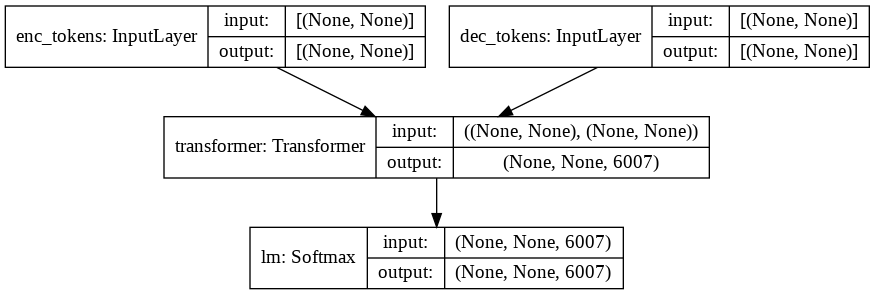

In [27]:
model = build_model(config)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer (Transformer)       (None, None, 6007)   2509952     enc_tokens[0][0]                 
                                                                 dec_tokens[0][0]                 
__________________________________________________________________________________________________
lm (Softmax)                    (None, None, 6007)   0           transformer[0][0]            

In [29]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss

In [30]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

In [32]:
class InverseSquareRootSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    TransformerSchedule class
    """
    def __init__(self, d_model, warmup_steps=4000):
        """
        생성자
        :param d_model: 모델 hidden
        :param warmup_steps: warmup steps
        """
        super().__init__()

        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        arg1 = tf.math.rsqrt(step_num)
        arg2 = step_num * (self.warmup_steps**-1.5)
        arg = tf.math.minimum(arg1, arg2)
        lr = tf.math.rsqrt(self.d_model) * arg
        return lr

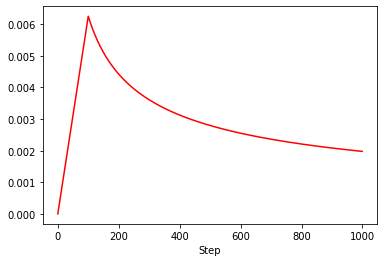

In [33]:
# compute lr
test_schedule = InverseSquareRootSchedule(config.d_model, warmup_steps=100)
lrs = []
for step in range(1000):
    lrs.append(test_schedule(float(step)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

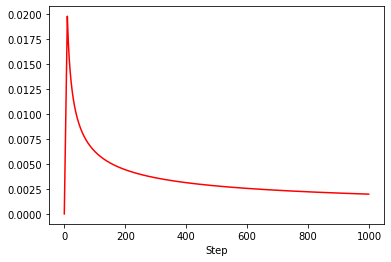

In [34]:
# compute lr
test_schedule = InverseSquareRootSchedule(config.d_model, warmup_steps=10)
lrs = []
for step in range(1000):
    lrs.append(test_schedule(float(step)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

In [35]:
# optimizer의 learning_rate를 InverseSquareRootSchedule로 지정
# learning_rate = InverseSquareRootSchedule(config.d_model, warmup_steps=10) # 500이었음
# optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

#우선은 테스트를 위해 고정 값으로 성능 확인
optimizer = tf.keras.optimizers.Adam()

model.compile(loss=lm_loss, optimizer=optimizer, metrics=[lm_acc])

In [36]:
#모델 학습

# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint("ko2jp_trans.hdf5", monitor="lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = model.fit(train_inputs, train_labels, epochs=40, batch_size=512, callbacks=[save_weights])

Epoch 1/40
313/313 [==============================] - 152s 463ms/step - loss: 1.1649 - lm_acc: 0.2071

Epoch 00001: lm_acc improved from -inf to 0.20715, saving model to ko2jp_trans.hdf5
Epoch 2/40
313/313 [==============================] - 145s 463ms/step - loss: 0.7268 - lm_acc: 0.4332

Epoch 00002: lm_acc improved from 0.20715 to 0.43319, saving model to ko2jp_trans.hdf5
Epoch 3/40
313/313 [==============================] - 145s 463ms/step - loss: 0.4704 - lm_acc: 0.5996

Epoch 00003: lm_acc improved from 0.43319 to 0.59956, saving model to ko2jp_trans.hdf5
Epoch 4/40
313/313 [==============================] - 145s 463ms/step - loss: 0.3863 - lm_acc: 0.6563

Epoch 00004: lm_acc improved from 0.59956 to 0.65631, saving model to ko2jp_trans.hdf5
Epoch 5/40
313/313 [==============================] - 145s 463ms/step - loss: 0.3489 - lm_acc: 0.6825

Epoch 00005: lm_acc improved from 0.65631 to 0.68252, saving model to ko2jp_trans.hdf5
Epoch 6/40
313/313 [==============================] -

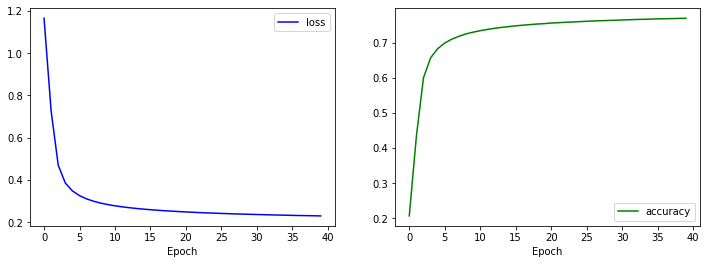

In [37]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [ ]:
# 기존 학습 weight 로드
model.load_weights("ko2jp_trans.hdf5")

In [38]:
def do_predict(model, n_seq, string):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param n_seq: 디코더 입력 개수
    :param string: 입력 문자열
    """
    # enc_token 생성: <string tokens>, [PAD] tokens
    enc_token = kor_vocab.encode_as_ids(string)
    # dec_token 생성: [BOS], [PAD] tokens
    dec_token = [jp_vocab.bos_id()]
    dec_token += [0] * (n_seq - len(dec_token))
    dec_token = dec_token[:n_seq]

    response = []
    for i in range(n_seq - 1):
        # model 실행
        output = model.predict((np.array([enc_token]), np.array([dec_token])))
        # decoder의 마지막 위치의 token 예측 값
        word_id = int(np.argmax(output, axis=2)[0][i])
        # [EOS] 토큰이 생성되면 종료
        if word_id == jp_vocab.eos_id():
            break
        # 예측된 token을 응답에 저장
        response.append(word_id)
        # 예측된 token을 decoder의 다음 입력으로 저장
        dec_token[i + 1] = word_id
    
    # 생성된 token을 문자열로 변경
    return jp_vocab.decode_ids(response)

In [39]:
string = '장하리 역을 맡게 된 배우다.'
do_predict(model, 20, string)

'チャン・ハリ役を演じるようになった俳優だ。'

In [40]:
string = '이 노래는 사랑하는 사람을 위한 노래다.'
do_predict(model, 20, string)

'この歌は愛する人のための歌だ。'

In [41]:
import nltk.translate.bleu_score as bleu

candidate = 'It is a guide to action which ensures that the military always obeys the commands of the party'
reference = 'It is a guide to action that ensures that the military will forever heed Party commands'

bleu.sentence_bleu([reference.split()],candidate.split())

0.41180376356915777

In [42]:
val_df=pd.read_csv(file_path+'/ko2ja_kpop_2_validation.csv')

In [43]:
val_df.shape

(20000, 9)

In [189]:
sample_val_df = val_df.loc[:19,:]

In [190]:
def cal_predcit(text):
  return do_predict(model, 200, text)

In [191]:
sample_val_df['predict'] = sample_val_df['한국어'].apply(cal_predcit)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [192]:
sample_val_df

,관리번호,분야,한국어,일본어,한국어_어절수,일본어_글자수,길이_분류,출처,수행기관,predict
0,KO-JA-2020-KPOP-160501,K-POP(한류)/대중문화공연콘텐츠,행사는 '인디펜던트 스프릿 어워즈(Independent Spirit Awards)'...,イベントは「インディペンデント・スプリット・アワード(Independent Spirit ...,20,74,4,http://news.kmib.co.kr/article/view.asp?arcid=...,플리토,行事は「インディペンダント・スプレットアワード(Independent Spirit Awa...
1,KO-JA-2020-KPOP-160502,K-POP(한류)/대중문화공연콘텐츠,다시 돌고 돌아 서울에서 81세 최고령 신청자가 '불효자는 웁니다'라는 곡을 정동원...,再び戻ってソウルで81才最高齢申請者が「不孝子は泣きます」という曲をチョン・ドンウォンに頼み...,27,92,5,http://www.sedaily.com/NewsView/1Z1IDQ5VDA,플리토,再びイルカで81歳最高齢申請者が「不孝子は大きいです」という曲をチョン・ドンウォンに頼み、幼...
2,KO-JA-2020-KPOP-160503,K-POP(한류)/대중문화공연콘텐츠,"생전 아버지가 오래 국회의원 보좌관을 했던 김무열은 ""아버지의 모든 걸 공감할 수 ...",生前、父親が永く国会議員の補佐官を務めたキム・ムヨルは「父親のすべてを共感することはできない...,20,72,4,http://www.sedaily.com/NewsView/1YYVBWQGCP,플리토,生前の父親が長く国会議員補佐官をしたキム・ムヨルは「父親のすべてを共感できないが、補佐官とい...
3,KO-JA-2020-KPOP-160504,K-POP(한류)/대중문화공연콘텐츠,지난 26일 SBS '본격 연예 한밤'에는 하정우와 이병헌이 출연해 영화 '백두산'...,26日SBS「本格芸能真夜」にはハ・ジョンウとイ・ビョンホンが出演し、映画「白頭山」に対して...,14,39,2,http://news.kmib.co.kr/article/view.asp?arcid=...,플리토,26日SBS「本格芸能真夜中」にはハ・ジョンウとイ・ビョンホンが出演し、映画「白頭山」に対し...
4,KO-JA-2020-KPOP-160505,K-POP(한류)/대중문화공연콘텐츠,"MC 신동엽이 손담비에 ""어머니가 결혼하라는 말씀은 안하시나""라고 물었다.",MCのシン・ドンヨプがソン・ダムビに「母親が結婚しろという話はしないのか」と聞いた。,8,35,1,http://en.seoul.co.kr/news/newsView.php?id=201...,플리토,MCシン・ドンヨプがソン・ダムビに「母親が結婚するなんだよ」と尋ねた。
5,KO-JA-2020-KPOP-160506,K-POP(한류)/대중문화공연콘텐츠,세종은 천민인 장영실을 알아봐주고 그가 가진 능력을 발휘할 수 있도록 배려해줬다.,世宗は賎民のジャン・ヨンシルを認めて彼が持つ能力を発揮できるように配慮してあげた。,11,39,2,http://www.sedaily.com/NewsView/1VS3J41PUT,플리토,世宗はチョンミンインのチャン・ヨンシルを調べて彼が持つ能力を発揮できるように配慮してくれた。
6,KO-JA-2020-KPOP-160507,K-POP(한류)/대중문화공연콘텐츠,"아들과 엄마가 부딪치기도 하고 한발 물러나야 할 때의 에너지도 있었는데, 너무 잘해...",息子と母親がぶつかったり、一歩退かなければならない時のエネルギーもあったが、とてもよくやって...,12,46,2,https://www.nocutnews.co.kr/news/5262673,플리토,息子と母親がぶつかりもして一歩退くべき時のエネルギーもあったが、とても上手にしてくれた。
7,KO-JA-2020-KPOP-160508,K-POP(한류)/대중문화공연콘텐츠,그의 병역 기피 논란을 바라보는 대중의 비난은 여전하지만 오랜만에 복귀한 그를 향한...,彼の兵役忌避論議を眺める大衆の非難は相変わらずだが、久しぶりに復帰した彼への関心が熱い。,14,42,2,http://www.seoul.co.kr/news/newsView.php?id=20...,플리토,彼の兵役忌避論難を眺める大衆の非難は相変わらず、久しぶりに復帰した彼に向けられた関心が熱い。
8,KO-JA-2020-KPOP-160509,K-POP(한류)/대중문화공연콘텐츠,별풍선 15억의 레전드로 유명한 BJ 박가린이 뽀얀 속살을 드러냈다.,星の風船15億のレジェンドで有名な、BJパク・ガリンが白い肌を現した。,9,28,1,http://www.seoul.co.kr/news/newsView.php?id=20...,플리토,星風船15億のレジェンドで有名なBJパク・ガリンが白い中殺を現した。
9,KO-JA-2020-KPOP-160510,K-POP(한류)/대중문화공연콘텐츠,"'드림캐쳐'는 노래도 노래지만, 컴백 전 퍼포먼스에 대한 팬들의 기대가 높은 그룹이...",「DREAMCATCHER」は歌も歌だが、カムバック前パフォーマンスに対するファンの期待が高...,12,38,2,http://www.sedaily.com/NewsView/1YZ26IPY1M,플리토,「ドリームキャッチャー」は歌も歌もある歌もある歌もある。


In [226]:
sample_val_df['한국어'].loc[18]

'다음달 14일 개봉 예정인 영화 대통령의 7시간에 대한 영화팬들의 관심이 비상한 가운데 포털 관심영화 1위에 올라 화제다.'

In [228]:
# 한국어 원문에 대한 google_trans 구글 번역 결과, papago_trans 파파고 번역 결과

google_trans = [
                'イベントは、「インディペンデントスピリットアワード（Independent Spirit Awards）」が主催したイベントだったが、NYTはイベントの雰囲気を説明しながら「多くの人が棒監督に写真を撮ろうと求めた」と伝えた。',
                'また回り回って、ソウルで81歳最高齢申請者が「親不孝者は泣き」という曲をジョンドンウォンにお願いしたし、子供の頃、母と生き別れ事情を打ち明け得ている申請者は、孫のようなジョンドンウォンの声を聞くの特別な愛情を吐き出した。',
                '生前父が長く国会議員補佐官をしていたギムムヨルは「父のすべてを共感することができませんが、側近という職業に対する理解度は持っている」と打ち明けた。',
                '去る26日SBS「本格芸能真夜中」はハ・ジョンウとイ・ビョンホンが出演して、映画「白頭山」について話を交わした。',
                'MCシン・ドンヨプがソン・ダムビの「母が結婚という言葉はないハシナ」と尋ねた。',
                '世宗は賎民であるチャン・ヨンシルを調べてくれて、彼の能力を発揮できるように配慮してくれた。',
                '息子と母親がぶつかったりもして、一歩退くする際のエネルギーもあったが、あまりにも上手くれた。',
                '彼の兵役忌避論議を眺める大衆の非難は相変わらずだが、久しぶりに復帰した彼に向かって関心が熱い。',
                '別のバルーン15億のレジェンドで有名なBJバクガリンが真っ白肌を露出した。',
                '「ドリームキャッチャー」は歌も歌うが、カムバック前パフォーマンスに対するファンたちの期待が高いグループでもある。',
                '去る25日「歌謡大典」のリハーサル中残念事故が発生しました。',
                'ホ・ジノ監督がプレゼントする非常に特別な映画<ギフト>が来る10月28日公開を確定してキャラクターたちのコミカルケミが引き立つ30秒予告編を披露した。',
                '特にどの家具がどの階、どの位置、どのような方法の家を所有するかについての理解争いが生じないように、8集にそれぞれの長所と魅力を発散するようにすることがカギだった。',
                '昨日の午後放送されたMBC「ボクミョンガ王」ではノラジョの新しいメンバーウォンフムが「水族館」に出演した。',
                'ネチズンが激しく非難しましょう、最終的にミンチは、文を削除した。',
                '新しいメンバーが最初のバスキングを広げるのは、若い芸術家たちの天国として知られて、ドイツの首都ベルリンである。',
                '一方、新概念「親孝行芸能」で好評を集めているMBN「最高の一発」16回では、牧場体験に出た」ことがミネラル家族」の楽しい時繰り広げられる。',
                'JTBC「私を見つける」初放送前に、5分30秒のハイライトが公開された後、視聴者が最も待ち望ま場面がついに電波に乗る。',
                '来月14日に公開予定の映画大統領の7時間の映画ファンたちの関心が非常た中ポータル関心映画1位に上がって話題だ。',
                '例えば山に咲いている花が美しいし、その花を折ったり、こてに移しと鉢に植えておいて、自分の好みや好み通り育てることは愛ではなく、干渉であり、抑圧であり、暴力にほかならない。',
]

papago_trans = [
                'イベントは「インディペンデント·スプリット·アワーズ」（Independent Spirit Awards）が主催したイベントで、NYTはイベントの雰囲気を説明し、「多くの人が奉監督に写真を撮ろうと要請した」と伝えた。',
                'ソウルに戻り、ソウルで81歳の最高齢申請者が「親不孝者は泣きます」という曲をチョン·ドンウォンに頼み、幼い頃、母親と生き別れの事情を打ち明けた申請者は、孫のようなチョン·ドンウォンの声を聞くと、特別な愛情を示した。',
                '生前、父親が長く国会議員補佐官を務めたキム·ムヨルは「父親のすべてには共感できないが、補佐官という職業に対する理解度は持っている」と打ち明けた。',
                '今月26日、SBSの「本格芸能真夜中」にはハ·ジョンウとイ·ビョンホンが出演し、映画「白頭山（ペクトゥサン）」について話を交わした。',
                'MCとシン・ドンヨプがソン・ダムビに"母親が結婚するということはしないか"と尋ねた。',
                '世宗は賎民である蒋英実（チャン·ヨンシル）を調べ、彼が持つ能力を発揮できるように配慮した。',
                '息子と母親がぶつかったり、一歩退かなければならない時のエネルギーもあったが、とてもよくしてくださった。',
                '彼の兵役逃れ論議に対する大衆の非難は相変わらずだが、久しぶりに復帰した彼への関心が熱い。',
                '星風船15億のレジェンドで有名なBJ朴ガリンが白い素肌をさらけ出した。',
                'ドリームキャッチャーは歌も歌だが、カムバック前のパフォーマンスに対するファンの期待が高いグループでもある。',
                '今月25日の「歌謡大典」のリハーサル中に残念な事故が発生しました。',
                'ホ·ジンホ監督が贈る非常に特別な映画『贈り物』が10月28日公開を確定し、キャラクターたちのコミックなコンビネーションが引き立つ30秒予告編を披露した。',
                '特に、どの世帯がどの階、どの位置、どの方式の家を所有するかに対する利害争いが起きないよう、8集にそれぞれの長所と魅力を発散させることがカギだった。',
                '昨日午後に放送されたMBC「覆面歌王」では、ノラゾの新メンバー、ウォン·フムが「アクアリウム」として出演した。',
                'ネチズンが激しく非難すると、結局、ミンティは該当文を削除した。',
                '新しいメンバーが最初のバスキングを行う場所は、若い芸術家たちの天国として知られているドイツの首都ベルリンだ。',
                '一方、新概念の「親孝行芸能」として好評を得ているMBN「最高の一発」16話では、牧場体験に出た「スミの家族」の楽しいひとときが繰り広げられる。',
                'JTBC「Nittow」初放送前、5分30秒ハイライトが公開されて以降、視聴者が最も待ちわびていた場面がついに電波に乗る。',
                '来月14日に封切られる予定の映画「大統領の7時間」に対する映画ファンの関心が注がれている中、ポータル関心映画1位に上がり話題を呼んでいる。',
                '例えば、山に咲いている花が美しいとして、その花を折ったり、移植したてに移して植木鉢に植えておき、自分の好みや好みに合わせて育てることは、愛ではなく干渉であり、抑圧であり、暴力に他ならない。',
]

model_trans = list(sample_val_df['predict'])

references = list(sample_val_df['일본어'])

print(len(google_trans),len(papago_trans),len(model_trans),len(references))

20 20 20 20


In [230]:
google_bleu = []
papago_bleu = []
model_bleu = []

def sentence_jp_ids(text):
  return str(jp_vocab.encode_as_ids(text))

for i in range(len(sample_val_df['한국어'])):
  google_bleu.append(bleu.sentence_bleu([sentence_jp_ids(google_trans[i]).split(',')],sentence_jp_ids(references[i]).split(',')))
  papago_bleu.append(bleu.sentence_bleu([sentence_jp_ids(papago_trans[i]).split(',')],sentence_jp_ids(references[i]).split(',')))
  model_bleu.append(bleu.sentence_bleu([sentence_jp_ids(model_trans[i]).split(',')],sentence_jp_ids(references[i]).split(',')))

print('구글 번역기 평균 bleu: ',round(sum(google_bleu)/len(google_bleu),3))
print('파파고 평균 bleu: ',round(sum(papago_bleu)/len(papago_bleu),3))
print('모델 평균 bleu: ',round(sum(model_bleu)/len(model_bleu),3))

구글 번역기 평균 bleu:  0.498
파파고 평균 bleu:  0.606
모델 평균 bleu:  0.62
